# Bluebikes System-wide Analysis (Apr 2023 – Apr 2025)

_Columns expected:_
`ride_id, rideable_type, started_at, ended_at, start_station_name, start_station_id, end_station_name, end_station_id, start_lat, start_lng, end_lat, end_lng, member_casual`

This notebook aggregates monthly Bluebikes CSVs named like `YYYYMM-bluebikes-tripdata.csv` for the range 2023-04 through 2025-04, builds derived features, and replicates a story-style EDA with normal plots (no map tiles) for geographic visuals.

In [27]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

print('Libraries ready')

Libraries ready


## Load multiple months (Apr 2023 – Apr 2025)
Reads files named `YYYYMM-bluebikes-tripdata.csv`, skipping any that are missing, then concatenates into one DataFrame.

In [28]:
# Configure month range and file list
months = pd.date_range('2023-04-01', '2025-04-30', freq='MS')
file_list = [f"{dt.strftime('%Y%m')}-bluebikes-tripdata.csv" for dt in months]

dfs = []
for f in file_list:
    try:
        df_part = pd.read_csv(f)
        dfs.append(df_part)
        print(f"Loaded: {f} ({len(df_part):,} rows)")
    except Exception as e:
        print(f"Skipped: {f} ({e})")

if len(dfs) == 0:
    raise RuntimeError('No files loaded; ensure the CSVs exist in the working directory.')

df = pd.concat(dfs, ignore_index=True)
print(f"\nTotal combined rows: {len(df):,}")
print('Columns:', list(df.columns))

Loaded: 202304-bluebikes-tripdata.csv (296,291 rows)
Loaded: 202305-bluebikes-tripdata.csv (387,593 rows)
Loaded: 202306-bluebikes-tripdata.csv (367,839 rows)
Loaded: 202307-bluebikes-tripdata.csv (411,509 rows)
Loaded: 202308-bluebikes-tripdata.csv (441,706 rows)
Loaded: 202309-bluebikes-tripdata.csv (419,874 rows)
Loaded: 202310-bluebikes-tripdata.csv (435,867 rows)
Loaded: 202311-bluebikes-tripdata.csv (270,816 rows)
Loaded: 202312-bluebikes-tripdata.csv (169,380 rows)
Loaded: 202401-bluebikes-tripdata.csv (166,699 rows)
Loaded: 202402-bluebikes-tripdata.csv (231,947 rows)
Loaded: 202403-bluebikes-tripdata.csv (261,687 rows)
Loaded: 202404-bluebikes-tripdata.csv (356,327 rows)
Loaded: 202405-bluebikes-tripdata.csv (440,534 rows)
Loaded: 202406-bluebikes-tripdata.csv (478,860 rows)
Loaded: 202407-bluebikes-tripdata.csv (542,622 rows)
Loaded: 202408-bluebikes-tripdata.csv (538,262 rows)
Loaded: 202409-bluebikes-tripdata.csv (582,679 rows)
Loaded: 202410-bluebikes-tripdata.csv (564,156

## Parse timestamps and engineer features
Creates temporal columns, user labels, duration (minutes), and a simple geometric distance estimate (km).

In [29]:
# Parse timestamps
df['started_at'] = pd.to_datetime(df['started_at'], errors='coerce')
df['ended_at']   = pd.to_datetime(df['ended_at'],   errors='coerce')

# Temporal features
df['start_date']        = df['started_at'].dt.date
df['is_weekend']        = df['started_at'].dt.dayofweek >= 5
df['start_hour']        = df['started_at'].dt.hour
df['start_day_of_week'] = df['started_at'].dt.day_name()
df['start_month_name']  = df['started_at'].dt.month_name()
df['start_month']       = df['started_at'].dt.month
df['start_year']        = df['started_at'].dt.year

# User label normalization (Member/Casual)
df['user_type'] = df['member_casual'].astype(str).str.title()

# Trip duration (minutes)
df['trip_duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

# Simple great-circle approximation using degrees -> km heuristic (not route distance)
df['trip_distance_km'] = np.sqrt((df['start_lat'] - df['end_lat'])**2 + (df['start_lng'] - df['end_lng'])**2) * 111

# Round trip flag by station id
df['is_round_trip'] = (df['start_station_id'] == df['end_station_id'])

print('Feature engineering complete')
print(df[['started_at','user_type','trip_duration_min','trip_distance_km','is_round_trip']].head())

Feature engineering complete
           started_at user_type  trip_duration_min  trip_distance_km  \
0 2023-04-13 13:49:59    Member           5.083333          0.704393   
1 2023-04-25 09:44:38    Member           6.833333          1.457593   
2 2023-04-24 18:39:31    Casual          18.566667          5.348099   
3 2023-04-04 19:25:31    Member           6.716667          1.787941   
4 2023-04-11 08:36:14    Member          16.416667          2.614757   

   is_round_trip  
0          False  
1          False  
2          False  
3          False  
4          False  


## System overview
High-level metrics and composition across the full period.

In [30]:
total_trips   = len(df)
n_months      = df[['start_year','start_month']].drop_duplicates().shape[0]
n_stations    = pd.unique(list(df['start_station_name'].astype(str)) + list(df['end_station_name'].astype(str))).size
user_counts   = df['user_type'].value_counts()
date_span_min = pd.to_datetime(df['start_date']).min()
date_span_max = pd.to_datetime(df['start_date']).max()
days_covered  = (date_span_max - date_span_min).days + 1
daily_avg     = total_trips / days_covered if days_covered > 0 else np.nan

print(f"Period: {date_span_min} to {date_span_max} ({days_covered} days)")
print(f"Total trips: {total_trips:,}")
print(f"Months covered: {n_months}")
print(f"Active stations (approx unique): {n_stations}")
print(f"Avg daily trips: {daily_avg:,.0f}")
print('\nUser composition:\n', user_counts)

Period: 2023-04-01 00:00:00 to 2024-05-31 00:00:00 (427 days)
Total trips: 8,927,031
Months covered: 15
Active stations (approx unique): 581
Avg daily trips: 20,906

User composition:
 user_type
Member    6462605
Casual    2464426
Name: count, dtype: int64


## Ridership trends: daily and monthly
Daily volume curve and monthly totals across the period.

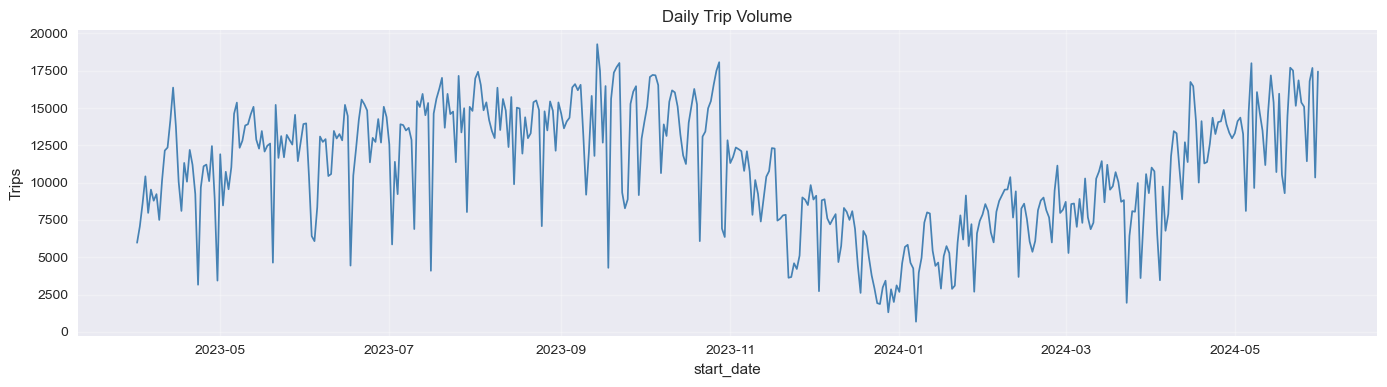

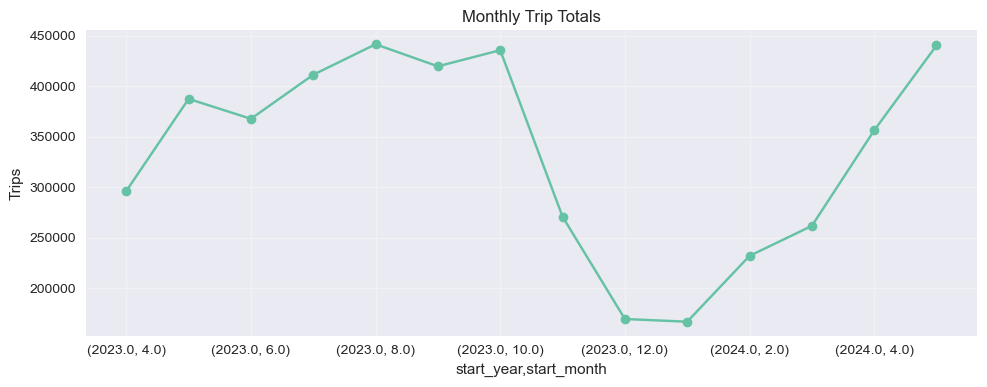

In [31]:
# Daily trend
daily_trips = df.groupby('start_date').size()
plt.figure(figsize=(14,4))
daily_trips.plot(color='steelblue', linewidth=1.25)
plt.title('Daily Trip Volume')
plt.ylabel('Trips')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Monthly trend (year-month index)
monthly_trips = df.groupby(['start_year','start_month']).size()
plt.figure(figsize=(10,4))
monthly_trips.plot(marker='o')
plt.title('Monthly Trip Totals')
plt.ylabel('Trips')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Weekday vs weekend and hourly usage
Compares average weekday vs weekend volumes and shows hourly usage patterns split by user type.

Avg weekday trips/day: 11,441
Avg weekend trips/day: 9,578


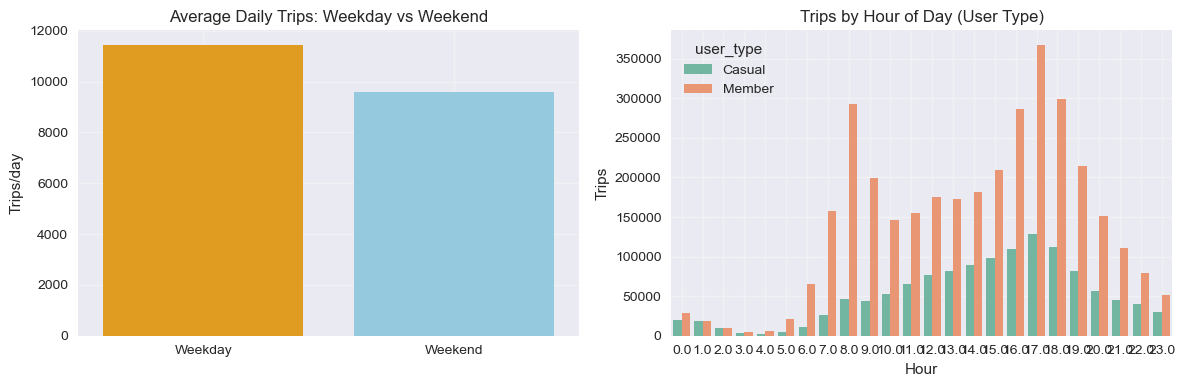

In [32]:
# Weekday vs weekend average
daily_df = df.groupby('start_date').agg(trips=('ride_id','count'), is_weekend=('is_weekend','first')).reset_index()
wkday_avg = daily_df.loc[~daily_df['is_weekend'],'trips'].mean()
wkend_avg = daily_df.loc[daily_df['is_weekend'],'trips'].mean()
print(f"Avg weekday trips/day: {wkday_avg:,.0f}\nAvg weekend trips/day: {wkend_avg:,.0f}")

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.barplot(x=['Weekday','Weekend'], y=[wkday_avg, wkend_avg], ax=ax[0], palette=['orange','skyblue'])
ax[0].set_title('Average Daily Trips: Weekday vs Weekend')
ax[0].set_ylabel('Trips/day')
ax[0].grid(alpha=0.3)

sns.countplot(data=df, x='start_hour', hue='user_type', ax=ax[1])
ax[1].set_title('Trips by Hour of Day (User Type)')
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Trips')
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Trip characteristics: duration and distance
Distribution and user-type differences for duration (minutes) and straight-line distance (km).

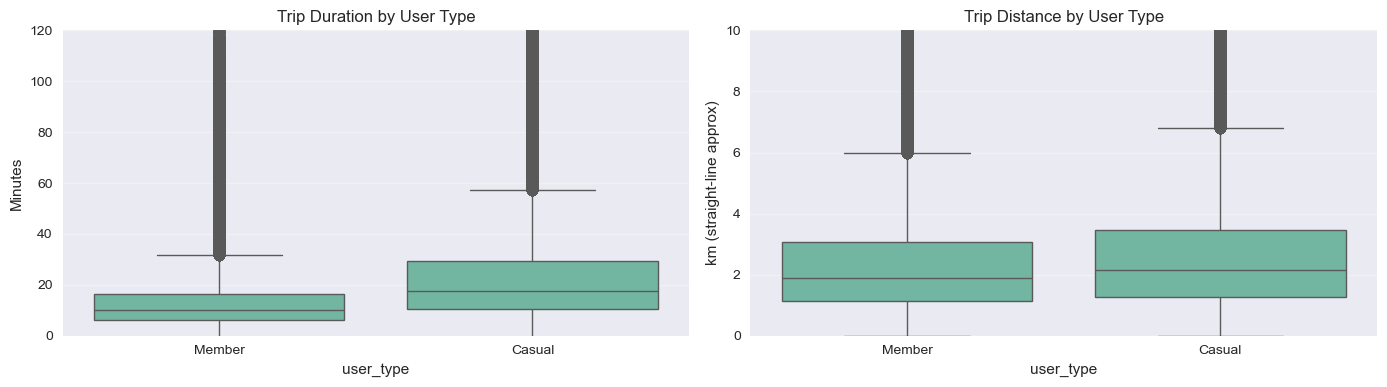

In [33]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.boxplot(data=df, x='user_type', y='trip_duration_min', ax=ax[0])
ax[0].set_title('Trip Duration by User Type')
ax[0].set_ylabel('Minutes')
ax[0].set_ylim(0, 120)
ax[0].grid(alpha=0.3)

sns.boxplot(data=df, x='user_type', y='trip_distance_km', ax=ax[1])
ax[1].set_title('Trip Distance by User Type')
ax[1].set_ylabel('km (straight-line approx)')
ax[1].set_ylim(0, 10)
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Station popularity
Top start stations by trip counts across the full period.

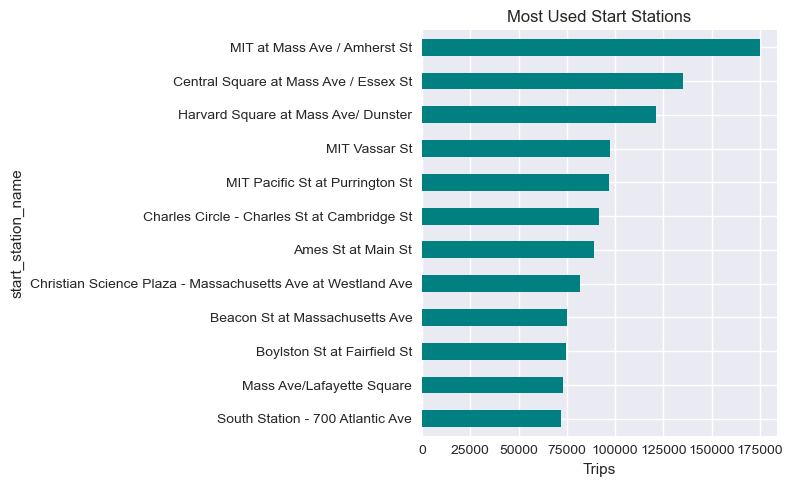

In [34]:
top_starts = df['start_station_name'].astype(str).value_counts().head(12)
plt.figure(figsize=(8,5))
top_starts.plot(kind='barh', color='teal')
plt.title('Most Used Start Stations')
plt.xlabel('Trips')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Round trips (start == end station)
Overall rate and user-type differences of round trips as a proxy for recreational usage.

Round trip percentage: 3.71%


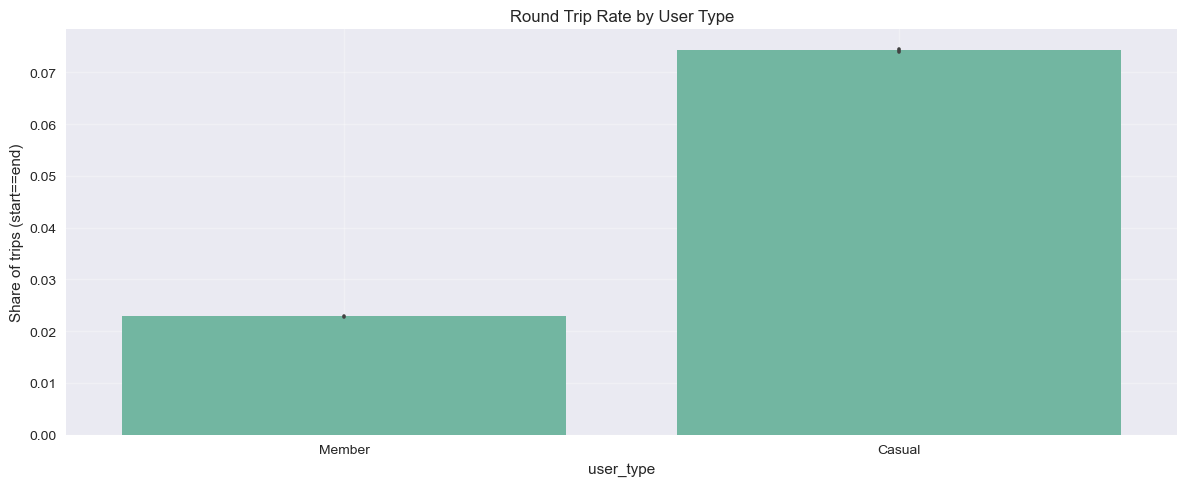

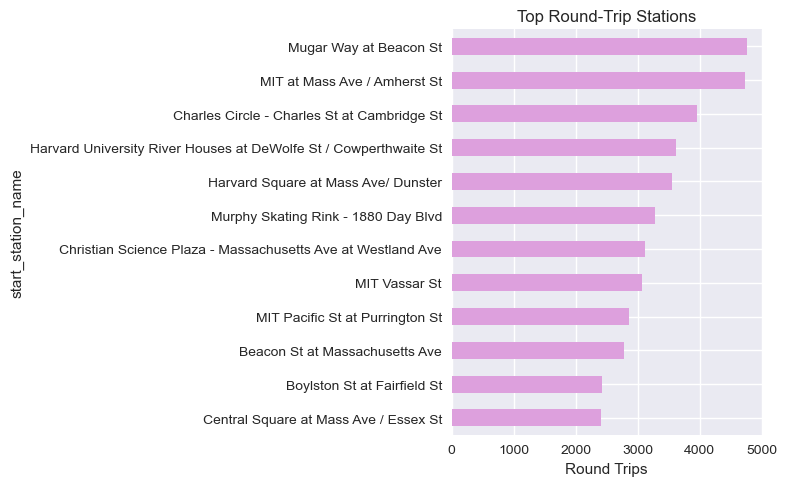

In [35]:
rt_pct = df['is_round_trip'].mean() * 100
print(f"Round trip percentage: {rt_pct:.2f}%")
sns.barplot(data=df, x='user_type', y='is_round_trip', estimator=np.mean)
plt.title('Round Trip Rate by User Type')
plt.ylabel('Share of trips (start==end)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Top round-trip stations (by count)
rt_stations = df.loc[df['is_round_trip']].groupby('start_station_name').size().sort_values(ascending=False).head(12)
plt.figure(figsize=(8,5))
rt_stations.plot(kind='barh', color='plum')
plt.title('Top Round-Trip Stations')
plt.xlabel('Round Trips')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Origin–Destination (OD) pairs
Most common station-to-station flows across the period.

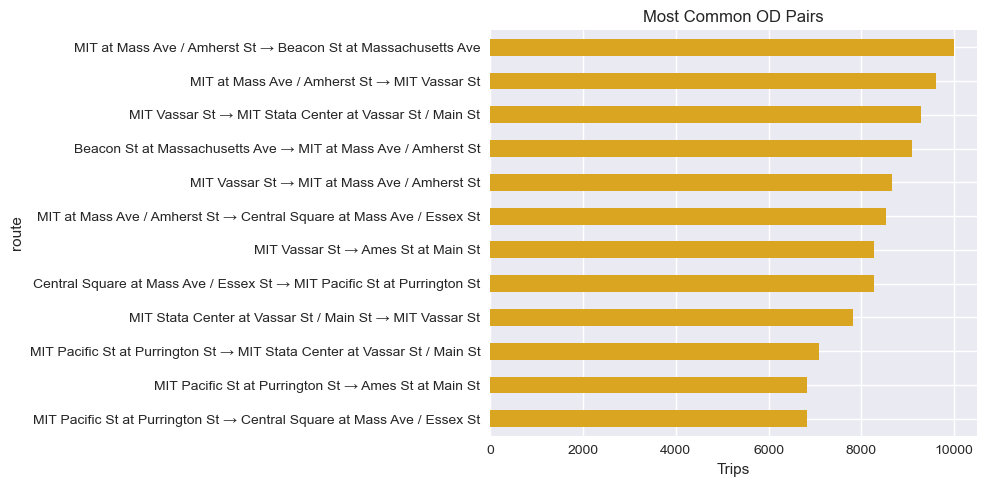

Unique OD pairs: 155974


In [36]:
df['route'] = df['start_station_name'].astype(str) + ' → ' + df['end_station_name'].astype(str)
top_routes = df['route'].value_counts().head(12)
plt.figure(figsize=(10,5))
top_routes.plot(kind='barh', color='goldenrod')
plt.title('Most Common OD Pairs')
plt.xlabel('Trips')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
print('Unique OD pairs:', df['route'].nunique())

## Geographic distribution (normal plots only)
Scatter of start and end coordinate clouds with no basemap tiles or heatmaps.

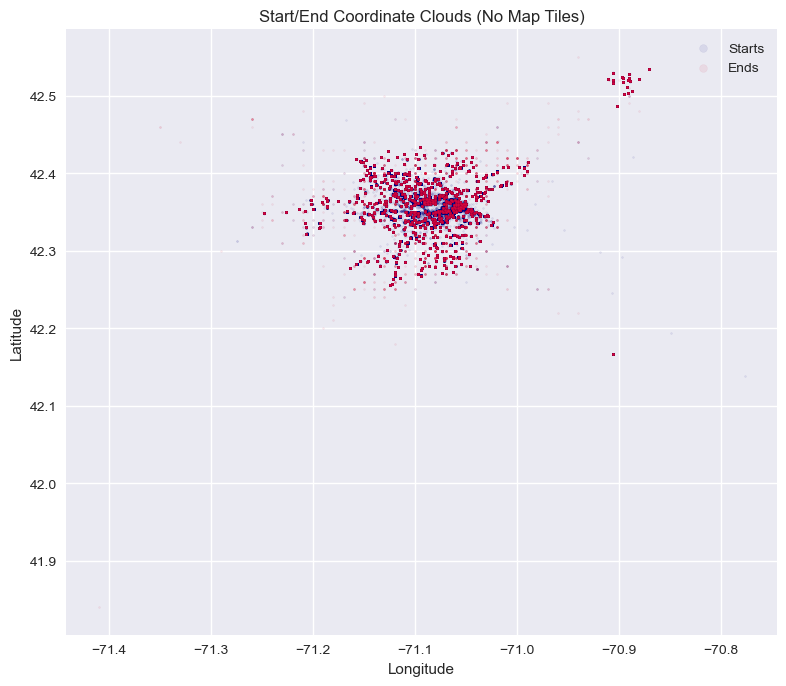

In [37]:
plt.figure(figsize=(8,7))
plt.scatter(df['start_lng'], df['start_lat'], s=2, alpha=0.08, label='Starts', color='navy')
plt.scatter(df['end_lng'],   df['end_lat'],   s=2, alpha=0.08, label='Ends',   color='crimson')
plt.title('Start/End Coordinate Clouds (No Map Tiles)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(markerscale=4)
plt.tight_layout()
plt.show()

## Executive summary (print key metrics)
Quick textual recap for reports.

In [38]:
peak_day = df.groupby('start_date').size().idxmax()
peak_cnt = df.groupby('start_date').size().max()
wkday_avg = daily_df.loc[~daily_df['is_weekend'],'trips'].mean()
wkend_avg = daily_df.loc[daily_df['is_weekend'],'trips'].mean()

print('='*70)
print('EXECUTIVE SUMMARY')
print('='*70)
print(f"Period: {date_span_min} to {date_span_max} ({days_covered} days)")
print(f"Total trips: {total_trips:,} | Avg daily: {daily_avg:,.0f}")
print(f"Peak day: {peak_day} with {peak_cnt:,} trips")
print(f"Weekday vs Weekend avg/day: {wkday_avg:,.0f} vs {wkend_avg:,.0f}")
print(f"Round-trip share: {rt_pct:.2f}%")
print('Top start stations:')
print(top_starts.head(5))
print('Top OD routes:')
print(top_routes.head(5))
print('='*70)

EXECUTIVE SUMMARY
Period: 2023-04-01 00:00:00 to 2024-05-31 00:00:00 (427 days)
Total trips: 8,927,031 | Avg daily: 20,906
Peak day: 2023-09-14 with 19,279 trips
Weekday vs Weekend avg/day: 11,441 vs 9,578
Round-trip share: 3.71%
Top start stations:
start_station_name
MIT at Mass Ave / Amherst St             175044
Central Square at Mass Ave / Essex St    135323
Harvard Square at Mass Ave/ Dunster      121208
MIT Vassar St                             97455
MIT Pacific St at Purrington St           96832
Name: count, dtype: int64
Top OD routes:
route
MIT at Mass Ave / Amherst St → Beacon St at Massachusetts Ave    9992
MIT at Mass Ave / Amherst St → MIT Vassar St                     9603
MIT Vassar St → MIT Stata Center at Vassar St / Main St          9278
Beacon St at Massachusetts Ave → MIT at Mass Ave / Amherst St    9091
MIT Vassar St → MIT at Mass Ave / Amherst St                     8664
Name: count, dtype: int64
